### VAE

In [1]:
%autosave 180
%load_ext autoreload
%autoreload 2
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=-1

Autosaving every 180 seconds
env: CUDA_VISIBLE_DEVICES=-1


In [2]:
import keras
import pandas as pd
import pylab as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML, clear_output

Using TensorFlow backend.


In [3]:
def create_data(n=10000):
    randn = np.random.normal
    X = randn(0, 1 , n)
    ind = np.random.randint(0, 2, n).astype(np.float32)
    mu1 = 2.0
    sigma1 = 0.3
    mu2 = -2.0
    sigma2 = 0.1
    Y = (1.0-ind) * randn(mu1, sigma1 , n) + ind * randn(mu2, sigma2, n) + X
    return X[..., None], Y[..., None], ind[..., None]

def get_model_input(n=10000):
    randn = np.random.normal
    input_x, input_y, index = create_data(n=n)
    input_z = randn(0, 1, n)
    out_y_avg_std = input_y.repeat(2, axis=1)
    out_y_avg_std = np.expand_dims(out_y_avg_std, axis=1)
    
    out_z_avg_std = np.zeros((n, 1, 2))
    return dict(
        index=index,
        input_x=input_x.astype(np.float32),
        input_y=input_y.astype(np.float32),
        input_z=input_z.astype(np.float32),
        out_y_avg_std=out_y_avg_std.astype(np.float32),
        out_z_avg_std=out_z_avg_std.astype(np.float32),
    )

In [4]:
data = get_model_input(n=10000)
for key in data:
    print(key, data[key].shape)

index (10000, 1)
input_x (10000, 1)
input_y (10000, 1)
input_z (10000,)
out_y_avg_std (10000, 1, 2)
out_z_avg_std (10000, 1, 2)


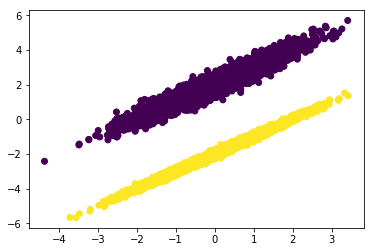

In [5]:
plt.scatter(data['input_x'], data['input_y'], c=data['index'])

In [6]:
from keras.models import Model
from keras.layers import Input, Concatenate
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten, Lambda, Permute
from keras.layers.advanced_activations import PReLU
from keras.optimizers import Adam, Nadam
from keras import backend as K



def likelihood_objective(y_true, y_pred):
    y_true = y_true[...,0]
    y_pred_avg = y_pred[...,0]
    y_pred_std = y_pred[...,1]
    
    y_pred_std = K.exp(y_pred_std)
    
    dav = y_true - y_pred_avg
    loss = .5*K.square(dav) / K.square(y_pred_std) + 0.5 * K.log(2.0*np.pi) + K.log(y_pred_std)
    loss = K.sum(loss, axis=-1)

    return loss

def kl_objective(y_true, z_avg_std):

    z_avg = z_avg_std[...,0]
    z_std = z_avg_std[...,1]
    z_log_var = 2.0 * z_std
    loss = - 0.5 * (1 + z_log_var - K.square(z_avg) - K.exp(z_log_var))
    loss = K.sum(loss, axis=-1)

    return loss


def K_sampling(args):
    out_z_avg_std, input_z = args
    z_mean = out_z_avg_std[...,0]
    z_std = out_z_avg_std[...,1]
    return z_mean + K.exp(z_std) * input_z

def create_model():

    models = {}
    input_x  = Input(shape=(1,), name="input_x")
    input_y  = Input(shape=(1,), name="input_y")
    input_z  = Input(shape=(1,), name="input_z")

    x = Concatenate(axis=-1)([input_x, input_y])
    for i in [32, 16, 8, 4, 2]:
        x = Dense(i, activation=None)(x)
        x = PReLU()(x)
        
    x = Dense(2)(x)
    out_z_avg_std = Reshape(target_shape=(1,2,), name='out_z_avg_std')(x)
    
    sample = Lambda(K_sampling, output_shape=(1,))([out_z_avg_std, input_z])
    
    models['encoder'] = Model(
        inputs=[input_x, input_y, input_z], 
        outputs=sample, 
        name='encoder'
    )
    
    models['z_avg_std'] = Model(
        inputs=[input_x, input_y], 
        outputs=out_z_avg_std, 
        name='out_z_avg_std'
    )
    
    x = Concatenate(axis=-1)([input_x, input_z])

    for i in [32, 16, 8, 4, 2]:
        x = Dense(i)(x)
        x = PReLU()(x)
        
    x = Dense(2)(x)
    out_y_avg_std = Reshape(target_shape=(1,2,), name='out_y_avg_std')(x)
    
    models['y_avg_std'] = Model(
        inputs=[input_x, input_z], 
        outputs=[out_y_avg_std], 
        name='out_y_avg_std'
    )
    
    output_decoder = models["y_avg_std"]([input_x, models["encoder"]([input_x, input_y, input_z])])
    
    models["vae"] = Model(
        inputs=[input_x, input_y, input_z], 
        outputs=[output_decoder, out_z_avg_std], 
        name='vae'
    )
    
    optimizer = Adam(lr=0.001) # 0.001
    
    models['vae'].compile(
        optimizer=optimizer,
        loss={
            'out_y_avg_std': likelihood_objective,
            'out_z_avg_std': kl_objective
        }
    )
    return models


In [7]:
models = create_model()

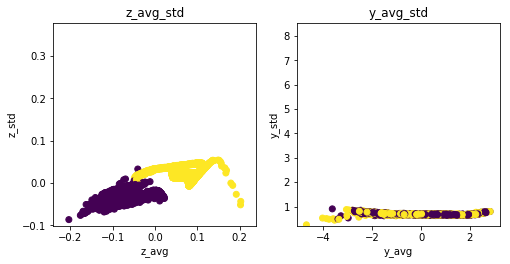

Train on 7000 samples, validate on 3000 samples
Epoch 1/1
7000/7000 [==============================] - 1s 144us/step - loss: 2.1157 - out_y_avg_std_loss: 2.1120 - out_z_avg_std_loss: 0.0038 - val_loss: 2.1187 - val_out_y_avg_std_loss: 2.1136 - val_out_z_avg_std_loss: 0.0052


In [ ]:
for i in range(100):
    models['vae'].fit(
        data, data, epochs=1,
        validation_split=.3,
        shuffle=True,
    )
    clear_output(wait=True)
    
    plt.figure(figsize=(8, 8))
    plt.subplot(121)
    plt.title('z_avg_std')
    z_avg_std = models['z_avg_std'].predict(data)
    z_avg_std = np.squeeze(z_avg_std)
    plt.scatter(z_avg_std[:,0], z_avg_std[:,1], c=np.squeeze(data['index']))
    plt.xlabel('z_avg')
    plt.ylabel('z_std')
    plt.axis('square')
    
    plt.subplot(122)
    plt.title('y_avg_std')
    y_avg_std = models['y_avg_std'].predict(data)
    y_avg_std = np.squeeze(y_avg_std)
    plt.scatter(y_avg_std[:,0], y_avg_std[:,1], c=np.squeeze(data['index']))
    plt.xlabel('y_avg')
    plt.ylabel('y_std')
    plt.axis('square')
    plt.show()